In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [74]:
!pip install mailbox

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import mailbox

mboxfile = "/content/drive/MyDrive/All_mail_Including_Spam_and_Trash.mbox"
mbox = mailbox.mbox(mboxfile)
mbox

In [77]:
for key in mbox[0].keys():
  print(key)

X-GM-THRID
X-Gmail-Labels
Delivered-To
Received
X-Google-Smtp-Source
X-Received
ARC-Seal
ARC-Message-Signature
ARC-Authentication-Results
Return-Path
Received
Received-SPF
Authentication-Results
DKIM-Signature
DomainKey-Signature
Return-Path
Received
Received-SPF
Received
Received
Date
From
To
X-Gm-Message-State
Message-ID
Subject
MIME-Version
Content-Type


## Data Transformation

* Data cleansing will be done for extracting the required fields since we do not need all the above keys
* The following fields will be extracted -
  * Subject
  * From
  * Date
  * To
  * Label
  * Thread


In [78]:
import csv

with open('mailbox.csv', 'w') as outputfile:
  writer = csv.writer(outputfile)
  writer.writerow(['subject','from','date','to','label','thread'])
  for message in mbox:
    writer.writerow([
        message['Subject'],
        message['From'],
        message['Date'],
        message['To'],
        message['X-Gmail-Labels'],
        message['X-GM-THRID']
    ])

In [79]:
# Reading the csv file
df = pd.read_csv('mailbox.csv', names=['subject','from','date','to','label','thread'],skiprows=1)
#df.head()

* Checking the datatypes present in the csv file
* Converting the dates to pandas `datetime` type

In [80]:
df.dtypes

subject    object
from       object
date       object
to         object
label      object
thread      int64
dtype: object

In [81]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))
df.dtypes

/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname CDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname CEST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname CST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/usr/local/lib/python3.7/dist-packages/dateutil/parser/_parser.py:1218: UnknownTi

subject                 object
from                    object
date       datetime64[ns, UTC]
to                      object
label                   object
thread                   int64
dtype: object

* Removing the `Nan` values

In [82]:
df = df[df['date'].notna()]
df.to_csv('/content/drive/MyDrive/gmail.csv')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63352 entries, 0 to 63404
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   subject  63200 non-null  object             
 1   from     63352 non-null  object             
 2   date     63352 non-null  datetime64[ns, UTC]
 3   to       63277 non-null  object             
 4   label    63352 non-null  object             
 5   thread   63352 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 3.4+ MB


## Data Refactoring

* The email address will be extracted from the `from` field using Regular Expressions
* If no email address exists, it will be populated with `NaN`

In [84]:
import re

def extract_email_ID(querystring):
  email = re.findall(r'<.+?>', querystring)
  if not email:
    email = list(filter(lambda y: '@' in y, querystring.split()))
  return email[0] if email else np.nan

In [85]:
df['from'] = df['from'].apply(lambda x: extract_email_ID(x))
#df.head()

* Refactoring the `label` field
* If an email was sent from my email address -> sent
* Else -> Received

In [86]:
myemail_1 = '<roy.aditya291@gmail.com>'
myemail_2 = '<royaroy29@yahoo.com>'
df['label'] = df['from'].apply(lambda x: 'sent' if x == myemail_1 or x == myemail_2 else 'inbox')
#df.tail()

* Dropping the `to` column since it only contains my email address

In [87]:
df.drop(columns='to', inplace=True)
#df.head(10)

## Refactoring Timezones

* Done using `datetime` and `pytz` libraries
* The days of the week and the time of the day when the email was received will be extracted using the `pandas`

In [88]:
import datetime
import pytz

def refactor_timezone(x):
  est = pytz.timezone('US/Eastern')
  return x.astimezone(est)

In [89]:
df['date'] = df['date'].apply(lambda x: refactor_timezone(x))
#df.head()

In [90]:
df['dayofweek'] = df['date'].apply(lambda x: x.day_name())
df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)
#df.head()

In [91]:
df['timeofday'] = df['date'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)
#df.head()

In [107]:
#df['hour'] = df['date'].apply(lambda x: x.hour)
#df.head()

In [93]:
df['year_int'] = df['date'].apply(lambda x: x.year)
df['year'] = df['date'].apply(lambda x: x.year + x.dayofyear/365.25)
df.index =df['date'] # Setting the index of the dataframe to the date
del df['date']

## Data Analysis

1. How many emails did I send during a given timeframe?
2. At what times of the day do I send and receive emails with Gmail?
3. What is the average number of emails per day?
4. What is the average number of emails per hour?
5. Whom do I communicate with most frequently?
6. What are the most active emailing days?
7. What am I mostly emailing about?

### 1. Number of Emails

In [94]:
print("Start of dataset: ",df.index.min().strftime('%a %d %b %Y %I:%M %p'))
print("End of dataset: ",df.index.max().strftime('%a %d %b %Y %I:%M %p'))
print(df['label'].value_counts())

Start of dataset:  Mon 12 Sep 2011 04:12 AM
End of dataset:  Mon 28 Jun 2021 08:53 PM
inbox    62180
sent      1172
Name: label, dtype: int64


In [95]:
sent = df[df['label']=='sent']
received = df[df['label']=='inbox']

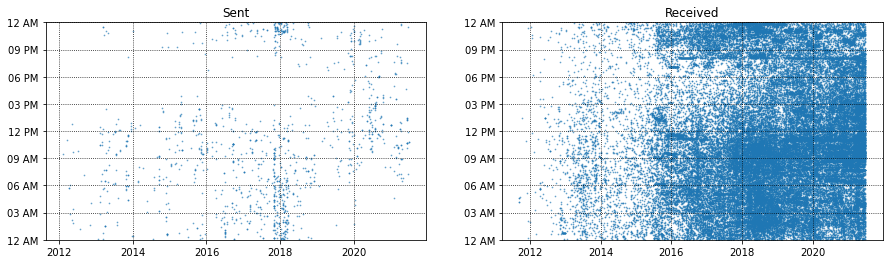

In [96]:
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

def plot_todo_vs_year(df, ax, color='C0', s=0.5, title=''):
  ind = np.zeros(len(df), dtype='bool')
  est = pytz.timezone('US/Eastern')
  df[~ind].plot.scatter('year','timeofday',s=s,alpha=0.6, ax=ax,color=color)
  ax.set_ylim(0,24)
  ax.yaxis.set_major_locator(MaxNLocator(8))
  ax.set_yticklabels([datetime.datetime.strptime(
      str(int(np.mod(ts,24))),"%H")
  .strftime("%I %p") for ts in ax.get_yticks()]);
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(title)
  ax.grid(ls=':', color='k')

  return ax

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
plot_todo_vs_year(sent, ax[0], title='Sent')
plot_todo_vs_year(received, ax[1], title='Received')
plt.savefig('/content/drive/MyDrive/mails_received_per_tod.png')

### 2. Average emails per day and hour


* The function will count the total number of emails per day and plot the average number of emails per day

In [97]:
def plot_number_perday_per_year(df, ax, label=None, dt=0.3, **plot_kwargs):
  year = df[df['year'].notna()]['year'].values
  T = year.max() - year.min()
  bins = int(T/ dt)
  weights = 1 / (np.ones_like(year) *dt *365.25)
  ax.hist(year, bins=bins, weights=weights, label=label, **plot_kwargs)
  ax.grid(ls=':', color='k')
  

In [98]:
def plot_number_perhour_per_year(df, ax, label=None, dt=1, 
                                 smooth=False, weight_fun=None, **plot_kwargs):
  # tod - time of day
  tod = df[df['timeofday'].notna()]['timeofday'].values
  year = df[df['year'].notna()]['year'].values
  Ty = year.max() - year.min()
  T = tod.max() - tod.min()
  bins = int(T / dt)
  if weight_fun is None:
    weights = 1 / (np.ones_like(tod) * Ty * 365.25/ dt)
  else:
    weights = weight_fun(df)
  if smooth:
    hst, xedges = np.histogram(tod, bins=bins, weights=weights);
    x = np.delete(xedges, -1) + 0.5 * (xedges[1] - xedges[0])
    hst = ndimage.gaussian_filter(hst, sigma=0.75)
    f = interp1d(x, hst, kind='cubic')
    x = np.linspace(x.min(), x.max(), 10000)
    hst = f(x)
    ax.plot(x, hst, label=label, **plot_kwargs)
  else:
    ax.hist(tod, bins=bins, weights=weights, label=label, **plot_kwargs);

  ax.grid(ls=':', color='k')
  orientation = plot_kwargs.get('orientation')
  if orientation is None or orientation == 'vertical':
      ax.set_xlim(0, 24)
      ax.xaxis.set_major_locator(MaxNLocator(8))
      ax.set_xticklabels([datetime.datetime.strptime(
          str(int(np.mod(ts,24))),"%H")
      .strftime("%I %p") for ts in ax.get_xticks()]);
  elif orientation == 'horizontal':
      ax.set_ylim(0, 24)
      ax.yaxis.set_major_locator(MaxNLocator(8))
      ax.set_yticklabels([datetime.datetime.strptime(
          str(int(np.mod(ts,24))),"%H")
      .strftime("%I %p") for ts in ax.get_yticks()]);


* Creating a class for plotting time of the day versus year for all the emails within a given timeframe

In [99]:
class TriplePlot:
  def __init__(self):
    gs = gridspec.GridSpec(6, 6)
    self.ax1 = plt.subplot(gs[2:6, :4])
    self.ax2 = plt.subplot(gs[2:6, 4:6], sharey=self.ax1)
    plt.setp(self.ax2.get_yticklabels(), visible=False);
    self.ax3 = plt.subplot(gs[:2, :4])
    plt.setp(self.ax3.get_xticklabels(), visible=False);

  def plot(self, df, color='darkblue', alpha=0.8, 
           markersize=0.5, yr_bin=0.1, hr_bin=0.5):
    plot_todo_vs_year(df, self.ax1, color=color, s=markersize)
    plot_number_perhour_per_year(df, self.ax2, dt=hr_bin,
                                 color=color, alpha=alpha,
                                 orientation='horizontal')
    self.ax2.set_xlabel('Average emails per hour')
    plot_number_perday_per_year(df, self.ax3, dt=yr_bin,
                                color=color, alpha=alpha)
    self.ax3.set_ylabel('Average emails per day')

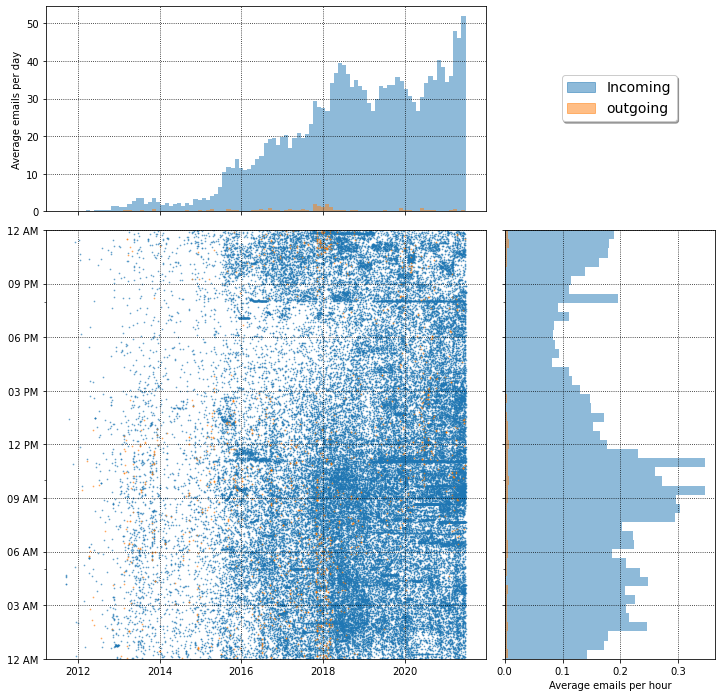

In [100]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

plt.figure(figsize=(12,12));
tripleplot = TriplePlot()
tripleplot.plot(received, color='C0', alpha=0.5)
tripleplot.plot(sent, color='C1', alpha=0.5)
p1 = mpatches.Patch(color='C0', label='Incoming', alpha=0.5)
p2 = mpatches.Patch(color='C1',label='outgoing', alpha=0.5)
plt.legend(handles=[p1,p2], bbox_to_anchor=[1.45, 0.7],
           fontsize=14, shadow=True);
plt.savefig('/content/drive/MyDrive/avg_mails_per_day.png')

### 3. Number of emails per day

* Which is the busiest day of the week as per emails?
According to the graph, it is Friday

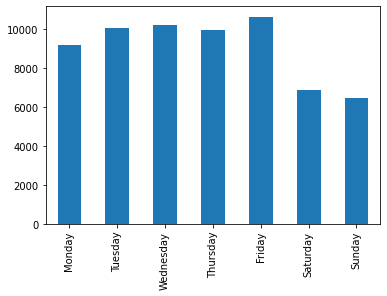

In [101]:
counts = df.dayofweek.value_counts(sort=False)
counts.plot(kind='bar');
plt.savefig('/content/drive/MyDrive/mails_received_per_day.png')

* Which are the most active days for receiving and sending emails separately?
  * Most Likely to send an email on Thursday
  * Most Likely to receive an email on Friday

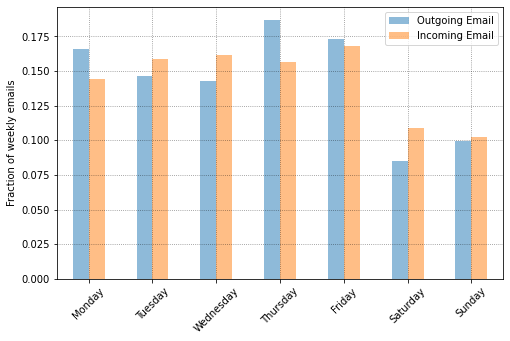

In [102]:
sent_day_week = sent.groupby('dayofweek').size()/len(sent)
received_day_week = received.groupby('dayofweek').size()/len(received)

df_tmp = pd.DataFrame(data={'Outgoing Email': sent_day_week, 
                            'Incoming Email': received_day_week})
df_tmp.plot(kind='bar', rot=45, figsize=(8,5), alpha=0.5)
plt.xlabel('');
plt.ylabel('Fraction of weekly emails');
plt.grid(ls=':', color='k', alpha=0.5)
plt.savefig('/content/drive/MyDrive/fraction_of_weekly_mails_per_day.png')


* Finding out most active time of the day for emails

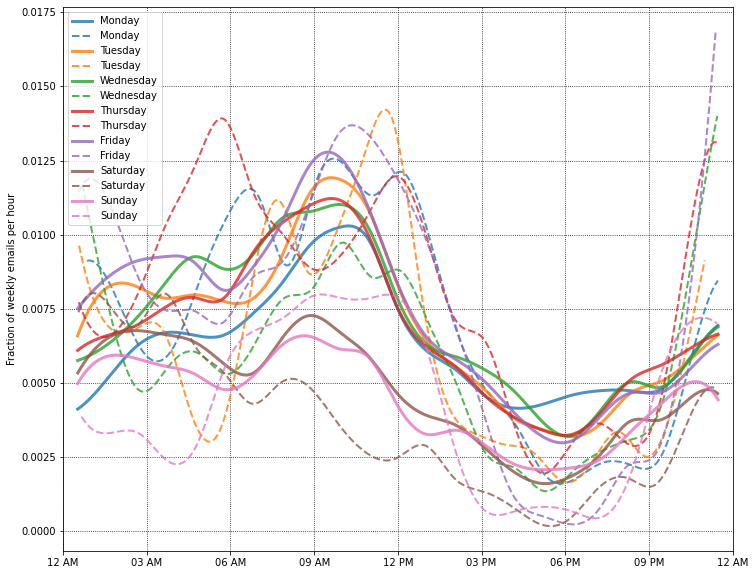

In [103]:
import scipy.ndimage
from scipy.interpolate import interp1d

plt.figure(figsize=(12,10))
ax = plt.subplot(111)
for ct, dow in enumerate(df.dayofweek.cat.categories):
  df_rec = received[received['dayofweek']==dow]
  weights = np.ones(len(df_rec)) / len(received)
  wfun = lambda x: weights
  plot_number_perhour_per_year(df_rec, ax, dt=1, smooth=True,color=f'C{ct}',
                               alpha=0.8, lw=3,label=dow, weight_fun=wfun)
  df_sent = sent[sent['dayofweek']==dow]
  weights = np.ones(len(df_sent)) / len(sent)
  wfun = lambda x: weights
  plot_number_perhour_per_year(df_sent, ax, dt=1, smooth=True,color=f'C{ct}',
                               alpha=0.8, ls='--',lw=2,label=dow, weight_fun=wfun)
ax.set_ylabel('Fraction of weekly emails per hour')
plt.legend(loc='upper left')
plt.savefig('/content/drive/MyDrive/fraction_of_mails_weekly_per_tod.png')

In [104]:
df.to_pickle('/content/drive/MyDrive/final_email_df.pkl')

In [108]:
df_pkl = pd.read_pickle('/content/drive/MyDrive/final_email_df.pkl')
#df_pkl.head()